In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats


import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing dataset

train = pd.read_csv('zillow/train.csv')

#Test for evaluation
test = pd.read_csv('zillow/test.csv')

In [3]:
#Outlier removal

print("Shape before removal ", train.shape)
#train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>2500) & (train['SalePrice']<300000)].index, inplace=True)
print("Shape after removal ", train.shape)

Shape before removal  (1460, 81)
Shape after removal  (1427, 81)


In [4]:
#Fixing typo

df_train = train.replace({"Exterior2nd":{"CmentBd":"CemntBd"}})

#Saving Id for further refference
Id = df_train['Id']

#Dropping Id from dataset
df_train.drop('Id', axis=1, inplace=True)  #For feature engeneering

In [5]:
#Function that split dataset to numerical and textual and check for missing values

def missing_numcat(data, categorical=True):
    """This function splits dataset into numerical and textual portion of the data and make dataframe with missing values"""
    if categorical:
        categorical_text = data.select_dtypes(include='object')
        categorical_cnt = categorical_text.count()
        cat_with_missing = categorical_cnt[categorical_cnt.values < len(data)]
        cat_percent =  (len(data) - cat_with_missing.values) / len(data)
        missing_categorical =pd.DataFrame({'values': cat_with_missing,
                                  'NaN vals':(len(data) - cat_with_missing.values), '(%) NaN':cat_percent})
        return missing_categorical
    else:
        numerical_data = data._get_numeric_data()
        numerical_cnt = numerical_data.count()
        num_with_missing = numerical_cnt[numerical_cnt.values < len(data)]
        num_percent =  (len(data) - num_with_missing.values) / len(data)
        missing_numerical =pd.DataFrame({'values': num_with_missing,
                                          'NaN vals':(len(data) - num_with_missing.values), '(%) NaN':num_percent}) 
        return missing_numerical

In [6]:
cat_missing = missing_numcat(df_train, categorical=True)
num_missing = missing_numcat(df_train, categorical=False)

In [7]:
#Missing data on cathegorical /Training

cat_missing 

,values,NaN vals,(%) NaN
Alley,86,1341,0.939734
MasVnrType,1420,7,0.004905
BsmtQual,1390,37,0.025929
BsmtCond,1390,37,0.025929
BsmtExposure,1389,38,0.026629
BsmtFinType1,1390,37,0.025929
BsmtFinType2,1389,38,0.026629
Electrical,1426,1,0.000701
FireplaceQu,742,685,0.480028
GarageType,1348,79,0.055361


In [8]:
#According to the documentation these cathegorical features should have No feature as string instead nan values
df_train['Alley'] = df_train['Alley'].fillna('No Alley Access')
df_train['BsmtQual'] = df_train['BsmtQual'].fillna('No Basement')
df_train['BsmtCond'] = df_train['BsmtCond'].fillna('No Basement')
df_train['BsmtExposure'] = df_train['BsmtExposure'].fillna('No Basement')
df_train['BsmtFinType1'] = df_train['BsmtFinType1'].fillna('No Basement')
df_train['BsmtFinType2'] = df_train['BsmtFinType2'].fillna('No Basement')
df_train['FireplaceQu'] = df_train['FireplaceQu'].fillna('No Fireplace')
df_train['GarageType']  = df_train['GarageType'].fillna('No Garage')
df_train['GarageFinish'] = df_train['GarageFinish'].fillna('No Garage')
df_train['GarageQual'] = df_train['GarageQual'].fillna('No Garage')
df_train['GarageCond'] = df_train['GarageCond'].fillna('No Garage')
df_train['PoolQC'] = df_train['PoolQC'].fillna('No Pool')
df_train['Fence'] = df_train['Fence'].fillna('NoFence')
df_train['MiscFeature'] = df_train['MiscFeature'].fillna('No msc feature')
df_train['MasVnrType'] = df_train['MasVnrType'].fillna('No Veneer')

In [9]:
#Check after imputation
missing_numcat(df_train, categorical=True)

,values,NaN vals,(%) NaN
Electrical,1426,1,0.000701


In [10]:
#Check for missing values in  numerical portion of the data
num_missing

,values,NaN vals,(%) NaN
LotFrontage,1175,252,0.176594
MasVnrArea,1420,7,0.004905
GarageYrBlt,1348,79,0.055361


## Target variable analysis                                                                              

In [11]:
#Target analysis and outlier detection
df_train.SalePrice.describe()

count      1427.000000
mean     179701.747022
std       79626.303537
min       34900.000000
25%      129250.000000
50%      161000.000000
75%      212000.000000
max      755000.000000
Name: SalePrice, dtype: float64

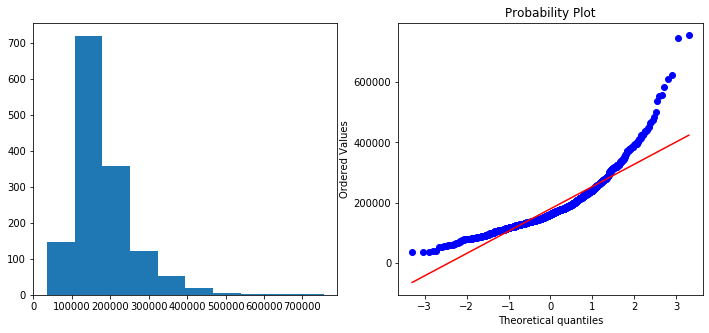

In [12]:
#Target Variable distribution

fig, (ax1, ax2) = plt.subplots(figsize=(12,5),ncols=2, sharey=False, )

#Q-Q plot
ax1.hist(df_train.SalePrice)
stats.probplot(df_train.SalePrice, plot = plt);

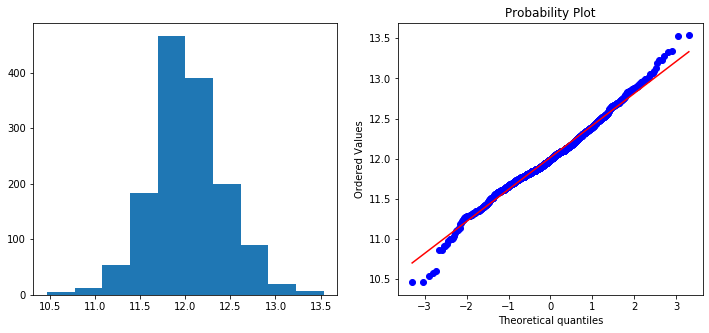

In [13]:
#Log transformed target variable

fig, (ax1, ax2) = plt.subplots(figsize=(12,5),ncols=2, sharey=False)

#Q-Q plot log transformed data

ax1.hist(np.log(df_train.SalePrice))
stats.probplot(np.log(df_train.SalePrice), plot = plt);

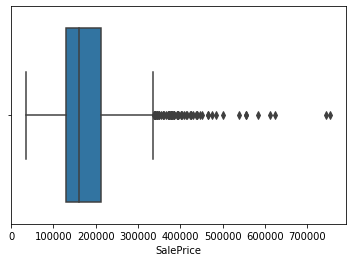

In [14]:
#Outlier detection using boxplot

s1 = sns.boxplot(df_train['SalePrice'], showfliers=True, )
plt.show()

### An Outlier Detection

In [15]:
#median is less than mean, distribution is positivly right skewed (1.88), Kurtosis indicates that we have
#outliers (6.54 > 3)
print("Skewenes: ", df_train.SalePrice.skew().round(2))
print("Kurtosis: ", df_train.SalePrice.kurt().round(2))
# We should consider log transformation for target variable

Skewenes:  1.94
Kurtosis:  6.76


In [16]:
#Outlier detection using z-score /whole dataset
def z_score_out_detect(data, target):
    q1 = np.percentile(data[target], 25)
    q3 = np.percentile(data[target], 75)
    iqr = q3 - q1
    print('Interquartile: ', iqr)
    upper = q3 + 1.5*iqr
    lower = q1-1.5*iqr
    print("Lower bound:",lower,"/", 'Upper bound:', upper)
    
    z_score = (data[target] - np.mean(data[target]))/ np.std(data[target])
    print((np.absolute(z_score)>2.5).sum())

In [17]:
z_score_out_detect(df_train, 'SalePrice') #whole dataset detecting about 40 rows to be outside lower/upper range

Interquartile:  82750.0
Lower bound: 5125.0 / Upper bound: 336125.0
40


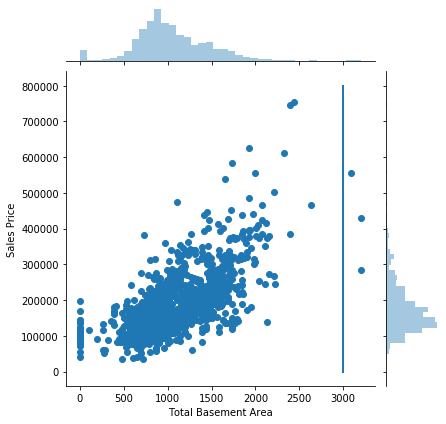

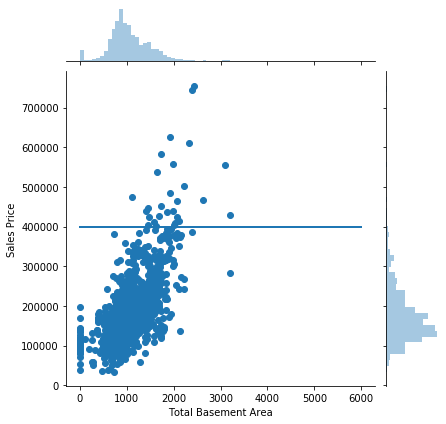

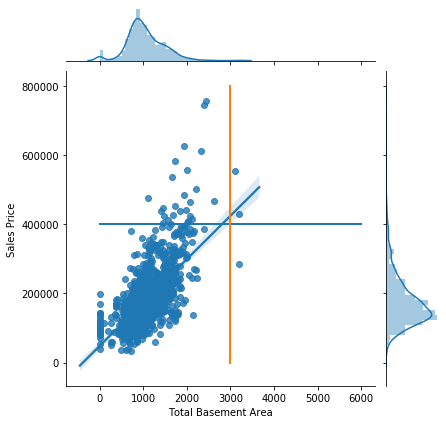

In [18]:
s1 = sns.jointplot(x="TotalBsmtSF", y="SalePrice", data=df_train)
s1.ax_joint.plot([3000, 3000], [0, 800000], linewidth=2)
s1.set_axis_labels(xlabel="Total Basement Area", ylabel="Sales Price")
s2 = sns.jointplot(x="TotalBsmtSF", y="SalePrice", data=df_train)
s2.ax_joint.plot([0, 6000], [400000, 400000], linewidth=2)
s2.set_axis_labels(xlabel="Total Basement Area", ylabel="Sales Price")
s3 = sns.jointplot(x="TotalBsmtSF", y="SalePrice", data=df_train, kind = "reg")
s3.ax_joint.plot([0, 6000], [400000, 400000], linewidth=2)
s3.ax_joint.plot([3000, 3000], [0, 800000], linewidth=2)
s3.set_axis_labels(xlabel="Total Basement Area", ylabel="Sales Price")

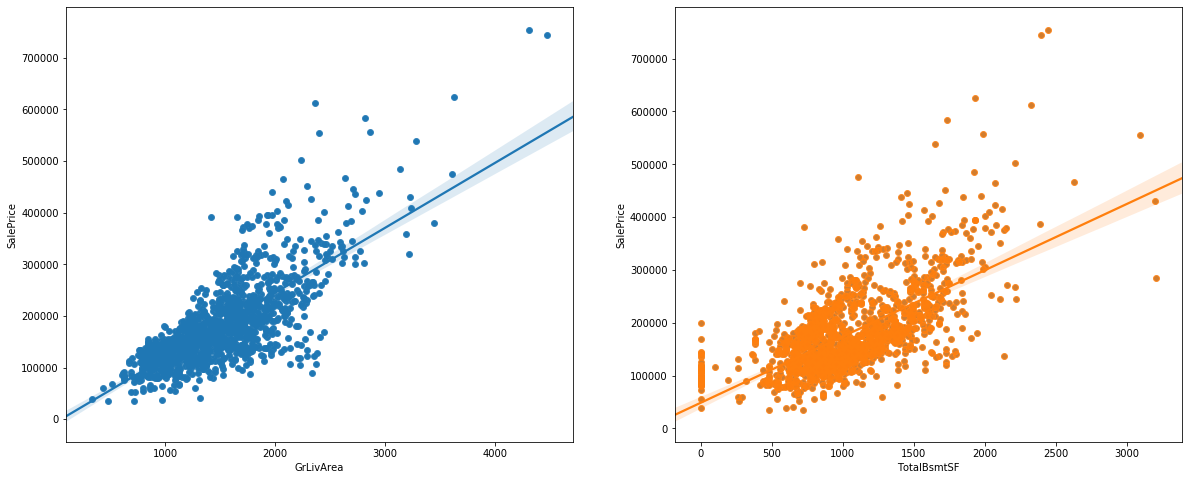

In [19]:
#Linearity for SalePrice featire with Two most correlated features

fig, (ax1, ax2) = plt.subplots(figsize=(20,8),ncols=2, sharey=False)

sns.scatterplot( x = df_train.GrLivArea, y = df_train.SalePrice,  ax=ax1)
sns.regplot(x=df_train.GrLivArea, y=df_train.SalePrice, ax=ax1)



sns.scatterplot( x = df_train['TotalBsmtSF'], y = df_train.SalePrice,  ax=ax2)
sns.regplot(x=df_train['TotalBsmtSF'], y=df_train.SalePrice, ax=ax2)

# Correlation

(38, 0)

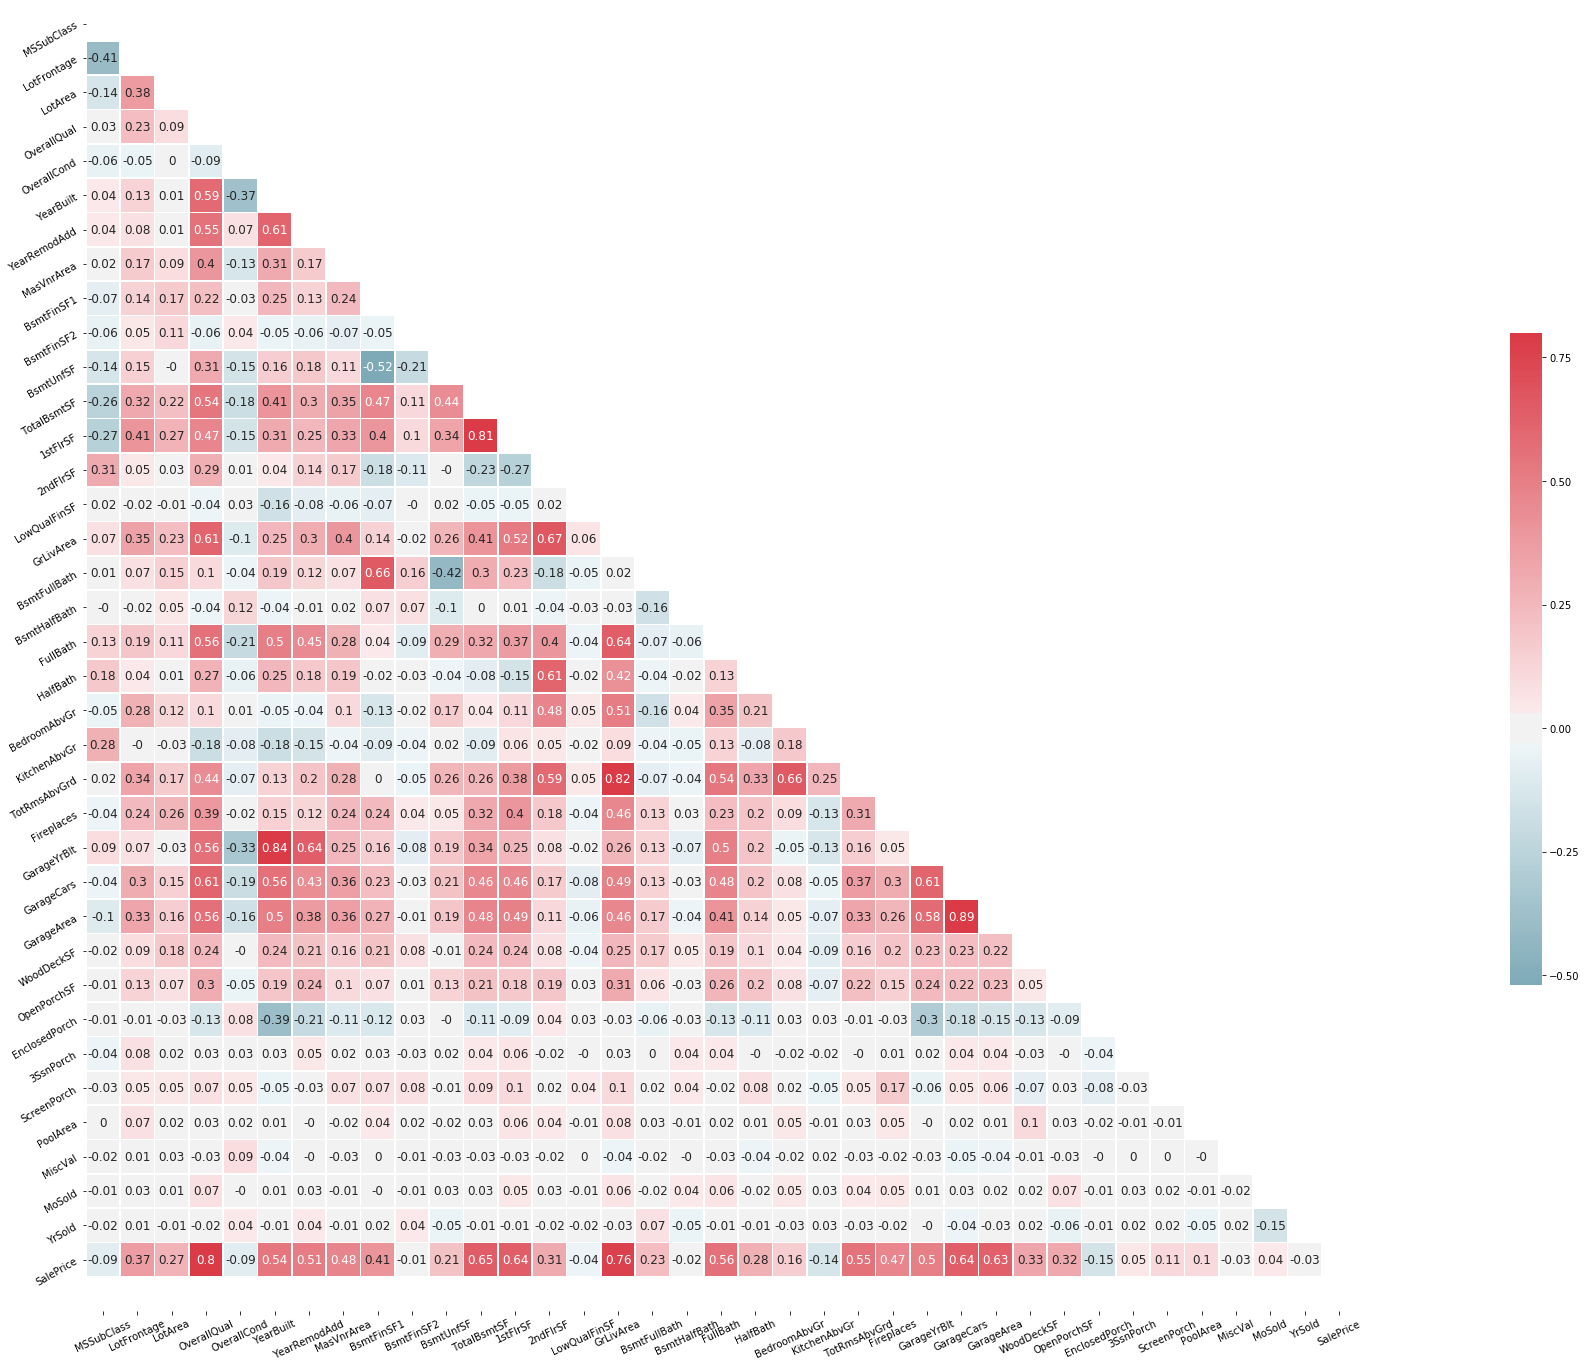

In [20]:
df_corr = df_train.copy()
corr_matrix = df_corr.corr().round(2)
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(55, 24))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"size": 12})
plt.yticks(rotation=30); 
plt.xticks(rotation=25);
ax.get_ylim()
ax.set_ylim(38, 0)

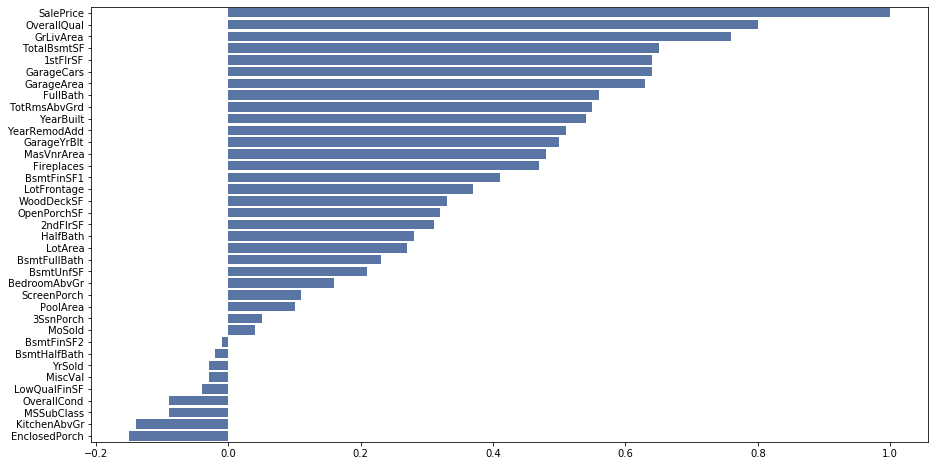

In [21]:
#Correlation - Sorted Features
corr_matrix = df_corr.corr().round(2)
sale_price_corr = corr_matrix['SalePrice'].sort_values(ascending=False)
f, ax = plt.subplots(figsize=(15, 8))
sns.set_color_codes("deep")
sns.barplot(x = sale_price_corr.values, y = sale_price_corr.index, color='b');

In [22]:
#Inspecting most correlated features
df_train['GrLivArea'].describe()
#df_train['GrLivArea'].value_counts().plot(kind='bar')  #

count    1427.000000
mean     1483.733006
std       477.977011
min       334.000000
25%      1124.500000
50%      1452.000000
75%      1743.500000
max      4476.000000
Name: GrLivArea, dtype: float64

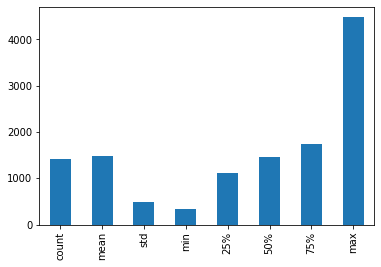

In [23]:
df_train['GrLivArea'].describe().plot(kind='bar')

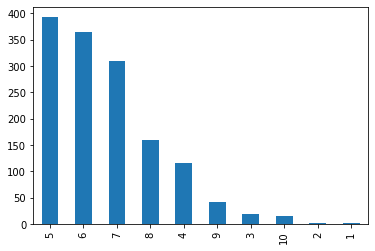

In [24]:
#OverallQuality
df_train['OverallQual'].describe()
df_train['OverallQual'].value_counts().plot(kind = 'bar')

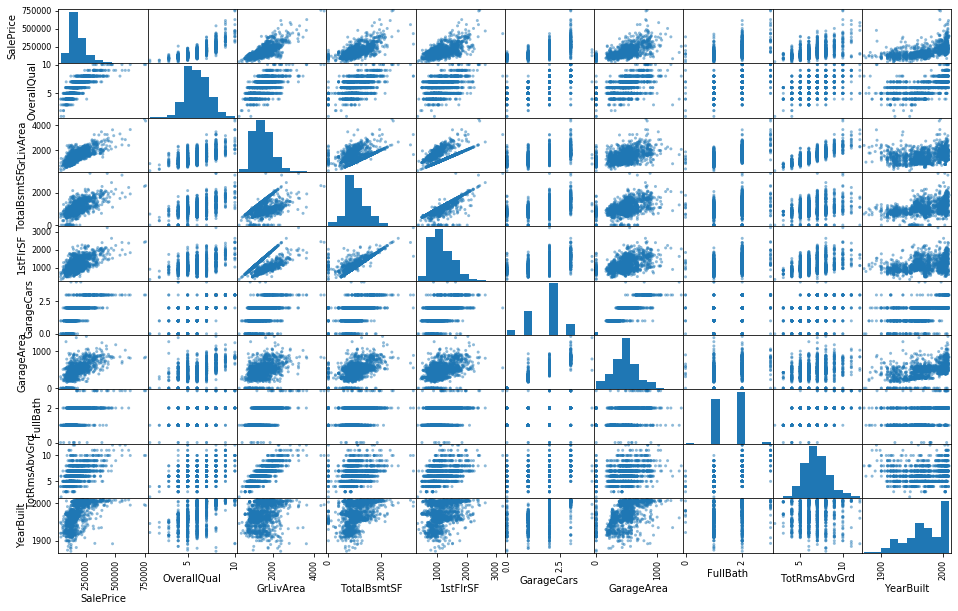

In [25]:
#Top 10 most correlated features with price

most_corr_features = sale_price_corr.index.tolist()

from pandas.plotting import scatter_matrix

scatter_matrix(df_train[most_corr_features[0:10]], figsize=(16,10));

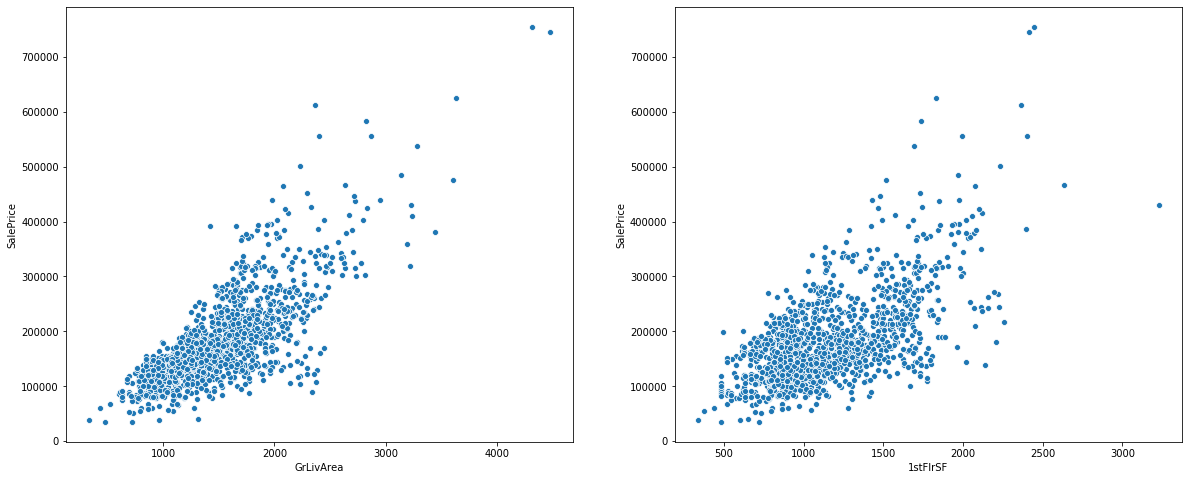

In [26]:
#SalePrice with Two most correlated features

fig, (ax1, ax2) = plt.subplots(figsize=(20,8),ncols=2, sharey=False)

sns.scatterplot( x = df_train.GrLivArea, y = df_train.SalePrice,  ax=ax1)
sns.scatterplot( x = df_train['1stFlrSF'], y = df_train.SalePrice,  ax=ax2)


In [27]:
df_train.select_dtypes('object').columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [28]:
#Evaluation test set
grade_dict = {'Excellent':5, 'Good':4,'Average/Typical':3,'Fair':2,'Poor':1}
test['ExterQual'] = test['ExterQual'].replace(grade_dict)
test['ExterCond'] = test['ExterCond'].replace(grade_dict)
test['BsmtQual'] = test['BsmtCond'].replace({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1, 'No Basement':0})
test['BsmtExposure'] = test['BsmtExposure'].replace({'Gd':4,'Av':3,'Mn':2, 'No':1,'No Basement':0})
test['BsmtFinType1'] = test['BsmtFinType1'].replace({
 'GLQ':6, 'ALQ':5,'BLQ':4,'Rec':3,
    'LwQ':2,'Unf':1,'No Basement':0
})
test['BsmtFinType2'] = test['BsmtFinType2'].replace({
 'GLQ':6, 'ALQ':5,'BLQ':4,'Rec':3,
    'LwQ':2,'Unf':1,'No Basement':0
})

test['HeatingQC'] = test['HeatingQC'].replace({'Ex':5, 'Gd':4,'TA':3,'Fa':2, 'Po':1 })
test['CentralAir'] = test['CentralAir'].replace({'No':0, 'Yes':1})
test['KitchenQual'] = test['KitchenQual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2, 'Po':1})
test['FireplaceQu'] = test['FireplaceQu'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'No Fireplace':0})
test['GarageQual'] = test['GarageQual'].replace({'Ex':4, 'Gd':4, 'TA':3,'Fa':2,'Po':1,'No Garage':0})
test['GarageCond'] = test['GarageCond'].replace({'Ex':4, 'Gd':4, 'TA':3,'Fa':2,'Po':1,'No Garage':0})
test['PoolQC'] = test['PoolQC'].replace({'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'No Pool':0})
test['Fence'] = test['Fence'].replace({'GdPrv':4,'MnPrv':3, 'GdWo':2, 'MnWw':1, "No Fence":0 })

In [29]:
#Training set
grade_dict = {'Excellent':5, 'Good':4,'Average/Typical':3,'Fair':2,'Poor':1}
df_train['ExterQual'] = df_train['ExterQual'].replace(grade_dict)
df_train['ExterCond'] = df_train['ExterCond'].replace(grade_dict)
df_train['BsmtQual'] = df_train['BsmtCond'].replace({'Ex':5, 'Gd':4,'TA':3,'Fa':2,'Po':1, 'No Basement':0})
df_train['BsmtExposure'] = df_train['BsmtExposure'].replace({'Gd':4,'Av':3,'Mn':2, 'No':1,'No Basement':0})
df_train['BsmtFinType1'] = df_train['BsmtFinType1'].replace({
 'GLQ':6, 'ALQ':5,'BLQ':4,'Rec':3,
    'LwQ':2,'Unf':1,'No Basement':0
})
df_train['BsmtFinType2'] = df_train['BsmtFinType2'].replace({
 'GLQ':6, 'ALQ':5,'BLQ':4,'Rec':3,
    'LwQ':2,'Unf':1,'No Basement':0
})

df_train['HeatingQC'] = df_train['HeatingQC'].replace({'Ex':5, 'Gd':4,'TA':3,'Fa':2, 'Po':1 })
df_train['CentralAir'] = df_train['CentralAir'].replace({'No':0, 'Yes':1})
df_train['KitchenQual'] = df_train['KitchenQual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2, 'Po':1})
df_train['FireplaceQu'] = df_train['FireplaceQu'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'No Fireplace':0})
df_train['GarageQual'] = df_train['GarageQual'].replace({'Ex':4, 'Gd':4, 'TA':3,'Fa':2,'Po':1,'No Garage':0})
df_train['GarageCond'] = df_train['GarageCond'].replace({'Ex':4, 'Gd':4, 'TA':3,'Fa':2,'Po':1,'No Garage':0})
df_train['PoolQC'] = df_train['PoolQC'].replace({'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'No Pool':0})
df_train['Fence'] = df_train['Fence'].replace({'GdPrv':4,'MnPrv':3, 'GdWo':2, 'MnWw':1, 'NoFence':0 })

In [30]:
df_train['Fence'].value_counts(dropna=False)

0    1154
3     153
4      56
2      53
1      11
Name: Fence, dtype: int64

In [31]:
#Convert some numerical to categorical in trainig set
df_train['YrSold'] = df_train['YrSold'].astype(str)
df_train['MoSold'] = df_train['MoSold'].astype(str) 
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].astype(str) 

In [32]:
#Convert some numerical to categorical in test set
test['YrSold'] = test['YrSold'].astype(str)
test['MoSold'] = test['MoSold'].astype(str) 
test['GarageYrBlt'] = test['GarageYrBlt'].astype(str) 

In [33]:
df_train = df_train.copy()
y = df_train.SalePrice  #Create target variable
X = df_train.drop(labels=['SalePrice'], axis=1).copy() #Cut SalePrice variable from training set

In [34]:
#Split  training dataset to train and test set
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.13, random_state=42)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=42)
for train_index, test_index in split.split(X, X['Neighborhood']):
    str_train = df_train.iloc[train_index]
    str_test   = df_train.iloc[test_index]

#OverallQual, TotRmsAbvGrd, BedroomAbvGr
y_train = str_train['SalePrice']
y_test  = str_test['SalePrice']
X_train = str_train.drop('SalePrice', axis = 1)
X_test = str_test.drop('SalePrice', axis = 1)


In [35]:
#Dealing with nan - Categorical
missing_cat_args = missing_numcat(X_train, categorical=True).index.tolist()
missing_cat_args

[]

In [36]:
#Dealing with nan - Numerical
missing_numcat(X_test, categorical=False)

,values,NaN vals,(%) NaN
LotFrontage,227,59,0.206294
MasVnrArea,283,3,0.010490


In [37]:
from sklearn.base import TransformerMixin, BaseEstimator

class UniversalImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
               """Impute missing values.

        If the Series is of dtype Object, then impute with the most frequent object.
        If the Series is not of dtype Object, then impute with the mean.  

        """
        
    def fit(self, X, y=None):
        
        self.fill = pd.Series([X[c].value_counts().index[0] if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
        index = X.columns)
        #if X.dtype == np.dtype('O'):
        #    self.fill = X.value_counts().index()[0]
        #else:
        #    self.fill = X.mean()    
    
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.fill)
        

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler, Normalizer
from sklearn.impute import SimpleImputer


housing_num = X_train._get_numeric_data()
housing_cat = X_train.select_dtypes('object')

In [39]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scal', MinMaxScaler()),
])

In [40]:
cat_pipeline = Pipeline([
    ('imput_cat', UniversalImputer()),
    ('one_hen', OneHotEncoder(handle_unknown='ignore')),
])

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
num_attrs = housing_num.columns.tolist()
cat_attrs = housing_cat.columns.tolist()
full_pipeline = ColumnTransformer([
    ('numerical_pl', num_pipeline, num_attrs),
    ('categorical_pl', cat_pipeline, cat_attrs ),
])
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)
test_prepared = full_pipeline.transform(test)

In [42]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score
#Score Display
def display_scores(scores):
    """This function display scores , mean and standard deviation uses scores as input"""
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# SGD Regressor

In [43]:
from sklearn import linear_model

sgd = linear_model.SGDRegressor(tol=1e-3, early_stopping=True, random_state=42)
sgd.fit(X_train_prepared, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=True, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [44]:
#SGD Cross validation
sgd_scores = cross_val_score(sgd, X_train_prepared, y_train,
                         scoring="neg_mean_squared_error", cv=10)
sgd_rmse_scores = np.sqrt(-sgd_scores)
display_scores(sgd_rmse_scores)

Scores: [30457.06882677 23569.84503788 27124.81495091 31514.21154843
 30047.48310455 22372.95624387 45028.75081683 42418.83262444
 31937.51144359 34772.62458014]
Mean: 31924.40991773982
Standard deviation: 6927.326302856566


# SVR

In [45]:
from sklearn.svm import SVR
clf = SVR()
clf.fit(X_train_prepared, y_train) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

# Ridge

In [46]:
from sklearn.linear_model import Ridge
rdg = Ridge(alpha=1, random_state=42, normalize=False)
rdg.fit(X_train_prepared, y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=42, solver='auto', tol=0.001)

In [47]:
#Ridge Cross Validation
ridge_scores = cross_val_score(rdg, X_train_prepared, y_train,
                         scoring="neg_mean_squared_error", cv=10)
ridge_rmse_scores = np.sqrt(-ridge_scores)
display_scores(ridge_rmse_scores)

Scores: [19520.508361   23266.32469757 21094.17829611 27764.2998338
 28490.22318312 22727.94584    30291.80198485 26605.03250839
 23309.48647801 25885.73268117]
Mean: 24895.553386402367
Standard deviation: 3276.945352050992


# Linear Regression

In [48]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_prepared, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [49]:
#Linear reg cross - validation


ridge_scores = cross_val_score(linreg, X_train_prepared, y_train,
                         scoring="neg_mean_squared_error", cv=10)
ridge_rmse_scores = np.sqrt(-ridge_scores)
display_scores(ridge_rmse_scores)

Scores: [21803.83308317 28201.55179499 20534.32516754 28128.09705925
 32556.91368314 28886.53593378 25389.58888955 27309.00823664
 22603.28649203 25749.71872439]
Mean: 26116.28590644821
Standard deviation: 3489.031897991441


# Elastic Net

In [50]:
from sklearn.linear_model import ElasticNet

elnet = ElasticNet(random_state=42)
elnet.fit(X_train_prepared, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=42, selection='cyclic', tol=0.0001, warm_start=False)

In [51]:
#ElasticNet Cross Validation


elnet_scores = cross_val_score(elnet, X_train_prepared, y_train,
                         scoring="neg_mean_squared_error", cv=10)
elnet_rmse_scores = np.sqrt(-elnet_scores)
display_scores(elnet_rmse_scores)

Scores: [41985.45091942 32448.83036716 45298.11157134 38505.75920724
 54101.78980575 41408.45891123 63742.43206545 58087.83852098
 56210.67227961 41741.71680004]
Mean: 47353.106044822016
Standard deviation: 9529.53263819519


# Lasso

In [52]:
from sklearn import linear_model
lso = linear_model.Lasso(alpha=0.1, random_state=42, warm_start=True, selection='random')
lso.fit(X_train_prepared, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=42,
      selection='random', tol=0.0001, warm_start=True)

In [53]:
#Lasso FIne Cross validation

lso_scores = cross_val_score(lso, X_train_prepared, y_train,
                         scoring="neg_mean_squared_error", cv=10)
lso_rmse_scores = np.sqrt(-lso_scores)
display_scores(lso_rmse_scores)

Scores: [21715.42709428 27706.57660977 20610.63944778 28093.46575421
 37271.95699094 28973.4199039  25455.31158498 27319.99632449
 22533.14212994 25733.17589106]
Mean: 26541.3111731358
Standard deviation: 4492.162191713239


# Decision Tree Regressor

In [54]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state=42, max_depth=10,min_samples_leaf=15)
dtr.fit(X_train_prepared, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=15,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [55]:
#Decission Tree FIne tuning

dtr_scores = cross_val_score(dtr, X_train_prepared, y_train,
                         scoring="neg_mean_squared_error", cv=10)
dtr_rmse_scores = np.sqrt(-dtr_scores)
display_scores(dtr_rmse_scores)

Scores: [34239.16779397 33567.52494093 31120.36448251 30195.62519548
 42947.34717431 31453.30039645 50336.18098353 44624.72405164
 39861.62295864 31638.02683453]
Mean: 36998.38848119996
Standard deviation: 6628.274896287623


# Random Forest

In [56]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=20,max_depth=20)
rf_reg.fit(X_train_prepared, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [57]:
#Random forest Tree FIne tuning

rfr_scores = cross_val_score(rf_reg, X_train_prepared, y_train,
                         scoring="neg_mean_squared_error", cv=10)
rfr_rmse_scores = np.sqrt(-rfr_scores)
display_scores(rfr_rmse_scores)

Scores: [22646.3637813  24970.25217066 23998.5590436  29055.39189534
 29667.21875716 20453.91350624 32443.35057818 31337.99518748
 27450.94314165 26871.54291403]
Mean: 26889.55309756598
Standard deviation: 3671.7672316870085


In [58]:
def evaluate(X_train, y_train, X_test, y_test, clf):
    clf_predict_train = clf.predict(X_train)
    clf_predict_test = clf.predict(X_test)
    clfmse_train = mean_squared_error(y_train, clf_predict_train)**0.5
    clfmse_test = mean_squared_error(y_test, clf_predict_test)**0.5
    clfrmse_train = mean_squared_log_error(y_train, clf_predict_train)**0.5
    clfrmse_test = mean_squared_log_error(y_test, clf_predict_test)**0.5
    print("Evaluate---","***", "----")
    print("RMSE-train",clfmse_train )
    print("RMSE-test", clfmse_test)
    print("RMSLE-train", clfrmse_train)
    print("RMSLE-test", clfrmse_test)

In [59]:
#SVR
evaluate(X_train_prepared, y_train, X_test_prepared, y_test, clf)

Evaluate--- *** ----
RMSE-train 84137.10897892319
RMSE-test 72816.54444575842
RMSLE-train 0.4062799564401968
RMSLE-test 0.37932365311078553


In [60]:
#Ridge
evaluate(X_train_prepared, y_train, X_test_prepared, y_test,rdg)


Evaluate--- *** ----
RMSE-train 18412.167096104735
RMSE-test 24083.906498783195
RMSLE-train 0.10473766869363882
RMSLE-test 0.14779864584878388


In [61]:
#Linreg
evaluate(X_train_prepared, y_train, X_test_prepared, y_test,linreg)

Evaluate--- *** ----
RMSE-train 17623.59882568929
RMSE-test 26310.352004550274
RMSLE-train 0.10346909389332166
RMSLE-test 0.28491204433274026


In [62]:
#Lasso
evaluate(X_train_prepared, y_train, X_test_prepared, y_test,lso)

Evaluate--- *** ----
RMSE-train 17623.674514358965
RMSE-test 26550.797510528337
RMSLE-train 0.1034371069184112
RMSLE-test 0.31774188830903966


In [63]:
#Decission tree
evaluate(X_train_prepared, y_train, X_test_prepared, y_test,dtr)

Evaluate--- *** ----
RMSE-train 29529.49142724353
RMSE-test 30438.049244992988
RMSLE-train 0.145440382624306
RMSLE-test 0.160947985943315


In [64]:
#Rndom forest
evaluate(X_train_prepared, y_train, X_test_prepared, y_test,rf_reg)

Evaluate--- *** ----
RMSE-train 11547.18284059316
RMSE-test 26101.127638572965
RMSLE-train 0.0642888289137656
RMSLE-test 0.13309895417572018


In [65]:
df_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [66]:
id_ = test['Id']
df_test = test.drop(['Id'], axis=1)

df_test['YrSold'] = df_test['YrSold'].astype(str)
df_test['MoSold'] = df_test['MoSold'].astype(str) 

In [67]:
df_test_final = full_pipeline.transform(df_test)

In [68]:
lso_predict = lso.predict(df_test_final)
linreg_predict = linreg.predict(df_test_final)
rdg_predict = rdg.predict(df_test_final)
rf_predict = rf_reg.predict(df_test_final)

In [70]:
final_df= pd.DataFrame(data=zip(id_,rf_predict), columns=['Id', 'SalePrice'])
final_df.to_csv('zillow/sample_submission.csv', index=False, columns=['Id', 'SalePrice'])
pd.read_csv('zillow/sample_submission.csv')

,Id,SalePrice
0,1461,130405.500000
1,1462,156432.500000
2,1463,177725.000000
3,1464,182376.666667
4,1465,193021.666667
...,...,...
1454,2915,89395.000000
1455,2916,86620.000000
1456,2917,150175.450000
1457,2918,123087.150000
